# Demonstrate Accessing SalishSeaCast NEMO Datasets from ERDDAP

This notebook is a demo of how to access results datasets from SalishSeaCast NEMO
via the ERDDAP server.
It uses `xarray` with the `netCDF4` backend to lazily load requested temporal/spatial
slices for specific variables.

Here is a `conda` environment description for running this notebook:
```yaml
name: ssc-nemo-erddap

channels:
  - conda-forge
  - nodefaults

dependencies:
  - arrow
  - black
  - bottleneck
  - cftime
  - cmocean
  - jupyterlab
  - matplotlib
  - nc-time-axis
  - netCDF4
  - pip
  - python=3.10
  - xarray
```

In [1]:
import xarray

## ERDDAP Dataset URLs

[xarray](https://docs.xarray.dev/en/stable/)
and [netCDF4](https://unidata.github.io/netcdf4-python/)
are able to use the [OPeNDAP](https://www.opendap.org/) protocol
to lazily access datasets from ERDDAP servers.
Lazy access means that opening the dataset results in just its metadata being downloaded.
That relatively small download allows you to explore the variables and spatial/temporal range
of the dataset to choose the subset of the dataset
(sometimes called a hyperslab)
that you want to work with.
The data are downloaded only when you do an operation that requires all of the data you are
requesting, not just the metadata.
Operations that trigger data downloads are things like plotting,
aggregation operations like averaging,
printing values at arbitrary points,
saving the data to a file,
etc.

**Note:**
It is very possible to request *huge* volumes of data.
ERDDAP servers have a response size limit of 2 Gb,
and will generally tell you fairly quickly if your request will exceed that limit.
If so,
you will need to reduce the spatial and/or temporal size of your request.
ERDDAP servers also do a lot of processing to extract the data your request from files
stored on the server.
They have time limits set for that processing to prevent errors or abuse from becoming
a Denial of Service (DoS) outage.
Unfortunately,
there is no way of knowing that your request is going to exceed the servers time limit
until it hits the limit.
The SalishSeaCast ERDDAP server has a 10 minute time limit.

So, best practice is to prototype the processing that you want to do against an ERDDAP server
with small data requests.
Then gently scale up the size of your requests to learn if/when you will hit the size and/or time limits.

To access an ERDDAP dataset using `xarray`,
use the dataset URL in the `xarray.open_dataset()` call;
e.g.
```python
ds = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV19-05")
```

The URL is composed of:
* the server's domain (that may include a path component)
* the string `griddap/`
* the dataset id

In the example above the server domain is `https://salishsea.eos.ubc.ca/erddap/`,
and the dataset id is `ubcSSg3DBiologyFields1hV19-05`.

You can find a list of the dataset ids on an ERDDAP server by visiting the server's `info/index.html` page;
e.g. https://salishsea.eos.ubc.ca/erddap/info/index.html.
The dataset ids are in the rightmost column on that page.

You can also get the dataset URL by using the URL of the `data` page in the leftmost "Grid DAP Data" column
on the index page and dropping the `.html` from the end of it.

`xarray` is a package for "working with labelled multi-dimensional arrays";
e.g. full water column or surface fields from multiple time steps of model products.
You will also see `data` links in the "Table DAP Data" column on the 
https://salishsea.eos.ubc.ca/erddap/info/index.html page.
Those datasets are typically things like observation time series that don't fit the definition
of "labelled multi-dimensional arrays".
They are conceptually two-dimensional tables.
The recommended package for working with those datasets is [pandas](https://pandas.pydata.org/).
`xarray` and `pandas` share many of the same concepts and have similar APIs
despite being designed to work with different kinds of underlying data structures.

## SalishSeaCast NEMO Datasets

So, here is the metadata for the biology fields from the SalishSeaCast NEMO SMELT model.
In a notebooks running on your computer
(in contrast to viewing this notebook on `nbviewer.org`)
you can click the icons to the right of the coordinates and data variables to see their
attributes and data representations.
You can also click the Attributes item at the bottom to see the datasets global attributes.

Providing as much metadata as possible is one of ERDDAP's design principles and a key feature.

In [2]:
ds = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV19-05")

In [3]:
ds

<xarray.Dataset>
Dimensions:                       (time: 121392, depth: 40, gridY: 898,
                                   gridX: 398)
Coordinates:
  * time                          (time) datetime64[ns] 2007-01-01T00:30:00 ....
  * depth                         (depth) float32 0.5 1.5 2.5 ... 414.5 441.5
  * gridY                         (gridY) int16 0 1 2 3 4 ... 894 895 896 897
  * gridX                         (gridX) int16 0 1 2 3 4 ... 394 395 396 397
Data variables:
    ammonium                      (time, depth, gridY, gridX) float32 ...
    biogenic_silicon              (time, depth, gridY, gridX) float32 ...
    ciliates                      (time, depth, gridY, gridX) float32 ...
    diatoms                       (time, depth, gridY, gridX) float32 ...
    dissolved_organic_nitrogen    (time, depth, gridY, gridX) float32 ...
    flagellates                   (time, depth, gridY, gridX) float32 ...
    mesozooplankton               (time, depth, gridY, gridX) float32 ...
    microzooplankton              (time, depth, gridY, gridX) float32 ...
    nitrate                       (time, depth, gridY, gridX) float32 ...
    particulate_organic_nitrogen  (time, depth, gridY, gridX) float32 ...
    silicon                       (time, depth, gridY, gridX) float32 ...
Attributes: (12/26)
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    comment:                   If you use this dataset in your research,\nple...
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             sallen@eoas.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    ...                        ...
    testOutOfDate:             now-16hours
    time_coverage_end:         2022-05-09T23:30:00Z
    time_coverage_start:       2007-01-01T00:30:00Z
    timeStamp:                 2022-May-09 18:19:32 GMT
    title:                     Green, Salish Sea, 3d Biology Fields, Hourly, ...
    uuid:                      d174eb60-faa2-424a-8cd6-e88aaa4ced9c

We can look at the metadata for a specific variable with:

In [4]:
ds.nitrate

<xarray.DataArray 'nitrate' (time: 121392, depth: 40, gridY: 898, gridX: 398)>
[1735439454720 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2007-01-01T00:30:00 ... 2022-05-09T23:30:00
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * gridY    (gridY) int16 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        40.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          dissolved_nutrients
    long_name:              Nitrate Concentration
    standard_name:          mole_concentration_of_nitrate_in_sea_water
    units:                  mmol m-3

The `x` and `y` coordinates of the SalishSeaCast NEMO datasets are integer grid indices.
So, you need to know the grid indices of the `x-y` locations you are interested in.
The `https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02` dataset provides
a mapping between `x-y` grid indices and longitudes/latitudes of the model grid points.

The `xarray.Dataset.isel()` method is the one to use to select the `x-y` range of your data requests
([User's Guide](https://docs.xarray.dev/en/stable/user-guide/indexing.html)
and [API](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.isel.html) docs).

Selections on the `time` and `depth` coordinates are done using the `xarray.Dataset.sel()` method
([User's Guide](https://docs.xarray.dev/en/stable/user-guide/indexing.html)
and [API](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html) docs).

In both cases,
coordinate ranges are selected using Python 
[slice](https://docs.python.org/3/library/functions.html#slice) objects.

`depth` coordinate values are floating point numbers so some accomodation is required for inexact matching.
That is most typically done by passing the `method="nearest"` argument to the `.sel()` call for `depth`.

## Time Series

So,
we can request a few hourly surface nitrate values
at the model grid point nearest to the Sentry Shoal buoy with:

In [16]:
sentry_shoal_ji = (707, 145)
j, i = sentry_shoal_ji
time_span = slice("2022-05-01 00:00:00", "2022-05-01 06:00:00")
surf_nitrate = (
    ds.nitrate
    .sel(time=time_span)
    .sel(depth=0, method="nearest")
    .isel(gridY=j, gridX=i)
)

**Note:**
The cell above executes very quickly because it defines the data selection
that we want.
It can do that using just the metadata that we got from the `xarray.open_dataset()`.
No fields data has been downloaded yet.
That is what "lazy loading" means.

The next cell,
where we cause field values to be displayed triggers a data download.
If you skipped it and went directly to the plotting cell below it,
that would trigger the data download.
But only one of the cells causes a download.
We won't trigger another download until we change the spatial/temporal location
or the shape of the data request.

In [17]:
surf_nitrate

<xarray.DataArray 'nitrate' (time: 6)>
array([11.081346, 12.650312, 12.766161, 11.184608, 10.732209, 10.455549],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-05-01T00:30:00 ... 2022-05-01T05:30:00
    depth    float32 0.5
    gridY    int16 707
    gridX    int16 145
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        40.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          dissolved_nutrients
    long_name:              Nitrate Concentration
    standard_name:          mole_concentration_of_nitrate_in_sea_water
    units:                  mmol m-3

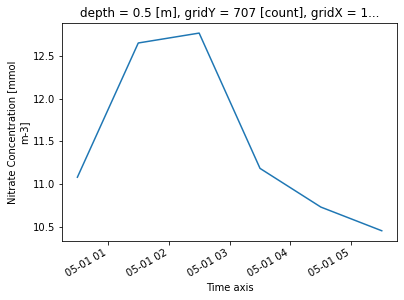

In [18]:
surf_nitrate.plot()

Increasing the length of the time series causes the data download to take longer.
The timing shown here is for a very fast network connection.

In [19]:
time_span = slice("2022-05-01 00:00:00", "2022-05-03 00:00:00")
surf_nitrate = (
    ds.nitrate
    .sel(time=time_span)
    .sel(depth=0, method="nearest")
    .isel(gridY=j, gridX=i)
)

CPU times: user 24.7 ms, sys: 282 µs, total: 24.9 ms
Wall time: 13.8 s


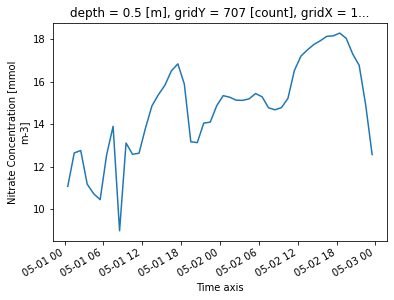

In [20]:
%%time
surf_nitrate.plot()

## Depth Profiles

For a depth profile we use a `slice()` for the `depth` coordinate,
and drop the `method="nearest"` because the asking for a range of depths
resolves the inexact matching issue for the floating point depth values.

For the `time` coordinate,
you need to know that the hourly values in SalishSeaCast NEMO results datasets
are hourly averages and their time stamps are the middle of hour averaged over;
i.e. the 30 minute mark.
Starting small with a single time for the nitrate profile from the grid points in the
top 25m of the water column averaged over the `2022-05-01 17:00:00` to `2022-05-01 18:00:00` hour:

In [30]:
depth_nitrate = (
    ds.nitrate
    .sel(time="2022-05-01 17:30:00")
    .sel(depth=slice(0, 25))
    .isel(gridY=j, gridX=i)
)

In [31]:
depth_nitrate

<xarray.DataArray 'nitrate' (depth: 21)>
array([16.838572, 16.849047, 17.13874 , 17.358456, 17.561789, 18.231882,
       19.08491 , 19.56322 , 19.733683, 19.771225, 19.825003, 19.899776,
       19.963154, 19.971022, 20.061787, 20.122625, 20.19588 , 20.32035 ,
       20.456753, 20.629965, 20.85145 ], dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-01T17:30:00
  * depth    (depth) float32 0.5 1.5 2.5 3.5 4.5 ... 18.01 19.48 21.39 24.1
    gridY    int16 707
    gridX    int16 145
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        40.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          dissolved_nutrients
    long_name:              Nitrate Concentration
    standard_name:          mole_concentration_of_nitrate_in_sea_water
    units:                  mmol m-3

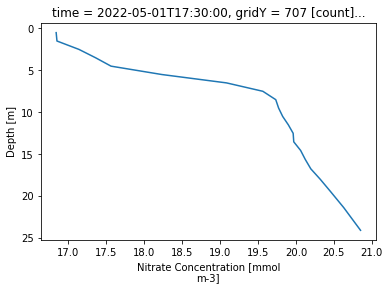

In [34]:
depth_nitrate.plot(y="depth", yincrease=False)

The [Plotting](https://docs.xarray.dev/en/stable/user-guide/plotting.html)
section of the xarray User's Guide has lots of information about how to control
the plot format.

We can use a `time` slice and facet plotting to look at the evolution of the
depth profile over a few hours:

In [36]:
depth_nitrate = (
    ds.nitrate
    .sel(time=slice("2022-05-01 15:30:00", "2022-05-01 17:30:00"))
    .sel(depth=slice(0, 25))
    .isel(gridY=j, gridX=i)
)

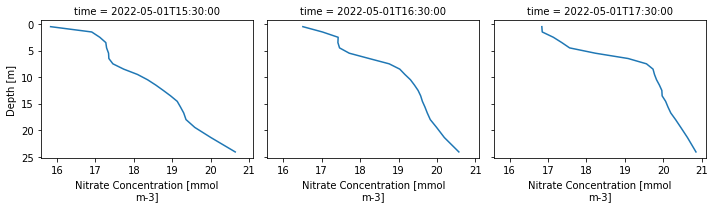

In [38]:
depth_nitrate.plot(y="depth", yincrease=False, col="time")

## Depth Slices

Requesting slices on the `gridY` and `gridX` coordinates lets us look at
dataset variable fields at various `time` and/or `depth` values.
Here we request the nitrate concentration fields at 5 depths in the grid cell nearest to the
Sentry Shoal buoy out to 5 grid cells away in each of the `x-y` directions
(i.e. a region about 5km square),
and plot the stack of fields using facetting.

In [60]:
nitrate_field = (
    ds.nitrate
    .sel(time="2022-05-01 17:30:00")
    .sel(depth=slice(0, 25, 5))
    .isel(gridY=slice(j-5, j+6), gridX=slice(i-5, i+6))
)

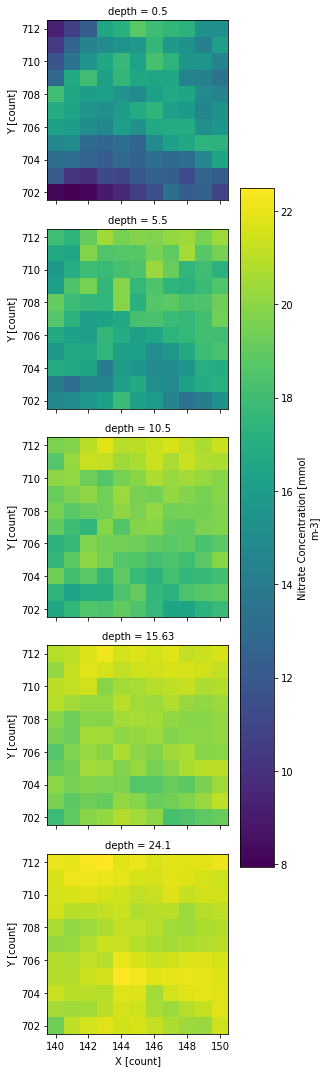

In [61]:
nitrate_field.plot(col="depth", col_wrap=1)